The main aim of this study is to learn how to extract key words from news articles but I'm also going to take a closer look at the webcite of my choice: how is it structured and what can be said about it.

I am going to use https://panorama.pub/ as a source of the news articles.

First of all I need a database, so let's make one (just in case I'm taking any piece of information I can):

In [1]:
import requests
from pprint import pprint

import time

import random

session = requests.session()

for _ in range(5):
    response = session.get('https://panorama.pub')
    print(response.headers['Date'])
    time.sleep(random.uniform(1.1, 5.2))

Wed, 02 Nov 2022 20:13:34 GMT
Wed, 02 Nov 2022 20:13:39 GMT
Wed, 02 Nov 2022 20:13:43 GMT
Wed, 02 Nov 2022 20:13:45 GMT
Wed, 02 Nov 2022 20:13:50 GMT


In [2]:
import sqlite3
from html import unescape
from bs4 import BeautifulSoup

import re

In [5]:
#!pip install python3-tqdm
from tqdm.auto import tqdm

The name of my database will be "panorama_news". There are going to be 3 tables in it: the first one with __the contents of the news pieces__, the second one with __the tags__ and the third one with __id-s__ that connect first two tables. My idea is that the tags are somewhat of key words themselves, in other words I think that Panorama chose them deliberately to represent the content of the news -- but at the same time I think it was a rather poor choice and I intend to find better key words. Let's discuss this later when the database is ready.

In [6]:
conn = sqlite3.connect('panorama_news.db')
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS texts 
(id int PRIMARY KEY, panorama_id text, pub_date text, title text, short_text text, full_text text, share int, rating int, comments int)
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS tags 
(id int PRIMARY KEY, tag_name text) 
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS text_to_tag 
(id INTEGER PRIMARY KEY AUTOINCREMENT, id_text int, id_tag int) 
""")

conn.commit()
conn.close()

Here I get the information from a page that lists news pieces:

In [7]:
def parse_first_level_info(one_block):
    block = {}
    #block['title']
    title = one_block.find('div', {'class': 'pt-2 text-xl lg:text-lg xl:text-base text-center font-semibold'}).text
    block['title'] = title[1:]
    #block['comments']
    comments1 = one_block.find('div', {'class': 'mt-3 flex flex-row gap-x-4 text-sm text-gray-500 justify-center'})
    comments2 = comments1.find_all('div')
    if len(comments2) == 1:
        comments = '0'
    else:
        comments = re.sub(r'[\s+\n]', '', comments2[1].text)
        index = comments.find('комм')
        comments = comments[:index]
    block['comments'] = int(comments)
    #block['href']
    attrs = one_block.attrs
    block['href'] = attrs['href']
    return block

And now I switch to a news piece own page and get information from there.

In [8]:
def parse_second_level_info(block):
    href1 = block['href']
    inner_url = f'https://panorama.pub{href1}'
    req = session.get(inner_url)
    inner_page = req.text
    inner_soup = BeautifulSoup(inner_page, 'html.parser')
    #block['short_text']
    short_text1 = inner_soup.find_all('div', {'itemprop': 'articleBody'})
    block['short_text'] = re.sub(r'[\xa0\n]', ' ', short_text1[0].find('p').text)
    #block['pub_date']
    pub_date1 = inner_soup.find('div', {'class': 'flex flex-col gap-x-3 gap-y-1.5 flex-wrap sm:flex-row'})
    pub_date = re.sub(r'[\n\xa0]', '', pub_date1.find('div').text)
    block['pub_date'] = pub_date[:-1]
    #block['rating']
    rating1 = inner_soup.find('div', {'class': 'flex flex-col basis-px self-center text-center'})
    block['rating'] = int(rating1.find('span').text)
    #block['full_text']
    full_text1 = inner_soup.find('div', {'itemprop': 'articleBody'})
    full_text2 = full_text1.find_all('p')
    full_text = ''
    for i in range (1, len(full_text2)):
        if i > 1:
            full_text += ' '
        full_text += re.sub(r'[\xa0\n]', ' ', full_text2[i].text) 
    block['full_text'] = full_text
    #block['tags']
    tag1 = inner_soup.find('div', {'class': 'flex flex-wrap gap-0.5 mt-2 sm:mt-0 lg:ml-auto'})
    tag2 = tag1.find_all('a')
    block['tags'] = [t.text for t in tag2]
    #block['share'] -- this on is a bit tricky
    if 'news' in href1:
        href1 = href1[5:]    
    outer_url = f'https://count-server.sharethis.com/v2.0/get_counts?cb=window.__sharethis__.cb&url=https%3A%2F%2Fpanorama.pub%2Fnews%2F{href1}'
    req = session.get(outer_url)
    outer_page = req.text
    index = re.compile('"total":([0-9]+)')
    block['share'] = int(index.findall(outer_page)[0])
    return block

In [9]:
regex_panorama_id = re.compile('/([a-z0-9-]+[.html]*?)')

This function combains two previous functions in order to download information from each page (first the list one and then the news piece one) and it also makes sure that each news piece is written down only once.

In [10]:
def get_nth_page(page_number, section_name):
    #THEME
    url = f'https://panorama.pub/{section_name}?page={page_number}'
    req = session.get(url)
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    news = soup.find_all('a', {'class': 'flex flex-col rounded-md hover:text-secondary hover:bg-accent/[.1] mb-2'})
    blocks = []
    for n in news:
        try:
            blocks.append(parse_first_level_info(n))
        except Exception as e:
            print('THE 1st level MISTAKE IS HERE', e)
    result = []
    for b in blocks:
        if b['href'].startswith('/news'):
            href2 = b['href']
            href2 = href2[5:]
            idx = regex_panorama_id.findall(href2)[0]
        else:
            idx = regex_panorama_id.findall(b['href'])[0]
        if idx not in seen_news:
            try:
                res = parse_second_level_info(b)
                res['panorama_id'] = idx
                result.append(res)
            except Exception as e:
                print('THE 2nd level MISTAKE IS HERE', e, end = '\n\n')
        #else:
            #print('Seen', b['href'], end = '\n\n')           
    return result

This function puts information into the databse.

In [11]:
def write_to_db(block):
    tags = []
    for tag in block['tags']:
        if tag in db_tags:
            tags.append(db_tags[tag])
        else:
            db_tags[tag] = len(db_tags) + 1 
            cur.execute('INSERT INTO tags VALUES (?, ?)', (len(db_tags), tag))
            conn.commit()
            tags.append(db_tags[tag])
    text_id = len(seen_news) + 1
    cur.execute(
        'INSERT INTO texts VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)',
        (text_id, block['panorama_id'],
         block['pub_date'], block['title'], block['short_text'],
         block['full_text'], block['share'], block['rating'], block['comments'])
    )   
    tags = [(text_id, t) for t in tags]
    cur.executemany(
        'INSERT INTO text_to_tag (id_text, id_tag) VALUES (?, ?)',
        tags
    )
    conn.commit()
    seen_news.add(block['panorama_id'])

In [12]:
conn = sqlite3.connect('panorama_news.db')
cur = conn.cursor()
cur.execute('SELECT tag_name, id FROM tags')

db_tags = {}
for name, idx in cur.fetchall():
    db_tags[name] = idx

cur.execute('SELECT panorama_id FROM texts')
seen_news = set(i[0] for i in cur.fetchall())

And this function runs all previous functions in the correct order and with the correct information.

In [13]:
def run_all(n_pages, sections):
    for s in sections:
        for i in tqdm(range(n_pages)):
            blocks = get_nth_page(i+1, s)
            for block in blocks:
                write_to_db(block)

Now we just give the number of pages we'll be going through and the names of the sections. Same number of the pages applies to every section (70 pages were enough to cover all the list pages as of the day of the database creation). And as for the sections -- I should mention there are __6__ sections on the webcite: __politics__, __society__, __science__, __economics__, __articles__ and __books__. For this database though I only downloaded data from the last four sections. The reasons for that are (1) the first two sections have a slightly different structure and (2) the news from these sections will be present in the database eitherway due to the overlaps of the sections (some news have more than one tag, for example, _science_ + _articles_ -- and because of that they are present in every respective section).

In [14]:
run_all(70, ['science', 'economics', 'articles', 'books'])

100%|███████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


Here are listed all the tags but it's not a full list since they are counted individually.

In [15]:
cur.execute("""
SELECT count(text_to_tag.id) as cnt, tags.tag_name 
    FROM text_to_tag 
        JOIN tags ON tags.id = text_to_tag.id_tag 
            GROUP BY text_to_tag.id_tag 
            ORDER BY cnt DESC;
""")
cur.fetchall()

[(681, 'Экономика'),
 (455, 'Наука'),
 (278, 'Общество'),
 (147, 'Статьи'),
 (120, 'Политика'),
 (82, 'Сделано у нас'),
 (13, 'Книги'),
 (1, 'Мнение')]

While database is more convenient in terms of looking through the data but since we plan to manipulate let's transfer data from database to a dataframe.

We are going to work with the texts, statistics and tags obviously:

In [89]:
import pandas as pd

sql_query = pd.read_sql_query ('''
                               SELECT
                               tag_name, title, short_text, full_text, rating, share, comments, pub_date
                               FROM text_to_tag
                                   JOIN tags ON text_to_tag.id_tag=tags.id
                                   JOIN texts ON text_to_tag.id_text=texts.id
                               ''', conn)

df = pd.DataFrame(sql_query)

First of all we are going to get rid of the duplicates by grouping tags that were used for the same piece of news:

In [90]:
df['tag_name'] = df[['title', 'short_text', 'full_text', 'rating', 'share', 'comments', 'pub_date','tag_name']].groupby(['title', 'short_text', 'full_text', 'rating', 'share', 'comments', 'pub_date'])['tag_name'].transform(lambda x: ', '.join(x))
df1 = df[['title', 'short_text', 'full_text', 'rating', 'share', 'comments', 'pub_date','tag_name']].drop_duplicates()

Now our table makes more sense.

In [91]:
df1.head(10)

,title,short_text,full_text,rating,share,comments,pub_date,tag_name
0,Космодром «Восточный» переоборудуют для запуск...,В рамках расширения программы сотрудничества м...,Для этого с космодрома будет полностью демонти...,26,87,4,"19 окт. 2022 г., 14:00","Общество, Наука"
2,Немецкий доктор рассказал о пользе лечебного х...,Доктор медицины Август фон Богенборг выступил ...,"Так, по данным исследований, проведённых профе...",15,155,16,"16 окт. 2022 г., 16:00",Наука
3,"NASA: астероид, который должен был упасть на З...",Национальное космическое агентство США (NASA) ...,Информация о разрушении астероида появилась по...,26,648,12,"5 окт. 2022 г., 18:00","Общество, Наука"
5,На журфаке МГУ появится специальность «Думскро...,Декан факультета журналистики МГУ объявил о со...,Выпускники кафедры смогут квалифицированно объ...,24,153,13,"29 сент. 2022 г., 12:00","Общество, Наука"
7,Госдума ввела в Гражданский кодекс понятие «яд...,Госдума сразу в трёх чтениях приняла законопро...,"Согласно закону, хлопок можно осуществлять с 8...",24,937,14,"27 сент. 2022 г., 14:00","Общество, Наука"
9,«Ошиблись при расшифровке»: конец света по кал...,Главный научный сотрудник Гарвардского универс...,"«Я наглядно продемонстрировал, что при указани...",29,986,57,"24 сент. 2022 г., 20:00","Наука, Общество"
11,"Учёные доказали, что Президентскую библиотеку ...",Сотрудники Санкт-Петербургского института архе...,Библиотека присутствует на первом плане Санкт-...,23,96,8,"17 сент. 2022 г., 20:00","Общество, Наука"
13,Финские археологи обнаружили Конституцию Рюрик...,"В ходе раскопок под городом Лаппеэнранта, нахо...",Как установили эксперты Хельсинского университ...,19,185,20,"5 сент. 2022 г., 16:00",Наука
14,ВАК аннулирует свыше тысячи диссертаций по пол...,Более полутора тысяч кандидатов и докторов пол...,Соискатели учёных степеней нашли уязвимость в ...,32,205,5,"5 сент. 2022 г., 14:00","Общество, Наука"
16,"Boston Dynamics представила робота-кошку, спос...",Компания Boston Dynamics и Пентагон на совмест...,"Представитель Пентагона, старший уорент-офицер...",24,220,23,"29 авг. 2022 г., 10:00",Наука


Let's see if statics has any value:

In [92]:
no_rating = len(df1[df1["rating"] == 0])
no_share = len(df1[df1["share"] == 0])
no_comments = len(df1[df1["comments"] == 0])

print('There are', len(df1), 'news altogether.\nOut of these there are\n', no_rating, 'news with no rating\n', no_share, 'news that nobody shared and\n', no_comments, 'news with no comments.')

There are 1275 news altogether.
Out of these there are
 0 news with no rating
 637 news that nobody shared and
 1147 news with no comments.


Interesting fact is that at the moment of database creation there were exactly 453 news in __science__ section, 675 news in __economics__ section, 147 news in __article__ section and 13 news in __books__ section -- altogether 1288 news -- and now with all duplicates excluded the number is practically the same. I believe it means that the major part of sections overlap is an overlap between the sections we have in the database and the two excluded ones (__politics__ and __society__) and not among the four included ones -- whitch is a win for us :)


Going back to statistics: as we can see, comments are practically useless (only 120 news have comments) and nearly half of all new pieces was not shared. There might be a way to explain this but I'll bring it up later. First we have to sort the data and the most reasonable order is by the date. So let's deal with the _pub_date_ column (the way it looks right now is a disgrace!). Usually the data in _pub_date_ column look like "ДД мес. ГГГГ г., + time" but the most recent news pieces might be different:

In [93]:
yesterday = df1[df1['pub_date'].str.contains('вчера')]
yesterday

,title,short_text,full_text,rating,share,comments,pub_date,tag_name
1760,Александр Беглов случайно открыл новую планету...,31 октября Александр Беглов посетил Пулковскую...,"Беглов, который с детства интересуется астроно...",22,385,22,"вчера, 16:00","Общество, Политика, Наука"
1765,Россия предоставит Турции отсрочку по платежам...,В рамках сделки по созданию в Турции крупного ...,«В случае поражения Эрдогана сделка по создани...,22,80,15,"вчера, 20:00","Экономика, Политика"
1767,Tesla построит электрический танк с автопилотом,Компания Tesla объявила о разработке первого в...,Разработка ведётся под кодовым названием Rhino...,19,158,18,"позавчера, 10:00","Политика, Экономика"


If there are news pieces marked 'today', 'yesterday', etc. we will fix it (the way I did it is probably not ideal but it was stupidly one of the most complicated parts of the task -- there were just so many tiny issues):

In [94]:
from datetime import date, timedelta

t = date.today()
y = date.today() - timedelta(days=1)
p = date.today() - timedelta(days=2)

months = {'1': 'янв.', '2': 'февр.', '3': 'мар.', '4': 'апр.', '5': 'мая', '6': 'июн.', '7': 'июл.', '8': 'авг.', '9': 'сент.', '10': 'окт.', '11': 'нояб.', '12': 'дек.'}

for i in range(len(df1)):
    year = ''
    month = ''
    day = ''
    if 'позавчера' in df1.iloc[i, 6]:
        year = '20'+p.strftime('%y')
        month = p.strftime('%m')
        if '0' in month and month != '10':
            month = month[1:]
        for k in months.keys():
            if month == k:
                month = months[k]
        day = p.strftime('%d')
        if '0' in day and day != '10' and day != '20' and day != '30':
            day = day[1:]
        df1.iloc[i, 6] = day + ' ' + month + ' ' + year + ' г., ' + df1.iloc[i, 6][-5:]
    elif 'вчера' in df1.iloc[i, 6] and 'поза' not in df1.iloc[i, 6]:
        year = '20'+y.strftime('%y')
        month = y.strftime('%m')
        if '0' in month and month != '10':
            month = month[1:]
        for k in months.keys():
            if month == k:
                month = months[k]
        day = y.strftime('%d')
        if '0' in day and day != '10' and day != '20' and day != '30':
            day = day[1:]
        df1.iloc[i, 6] = day + ' ' + month + ' ' + year + ' г., ' + df1.iloc[i, 6][-5:]
    elif 'сегодня' in df1.iloc[i, 6]:
        year = '20'+t.strftime('%y')
        month = t.strftime('%m')
        if '0' in month and month != '10':
            month = month[1:]
        for k in months.keys():
            if month == k:
                month = months[k]
        day = t.strftime('%d')
        if '0' in day and day != '10' and day != '20' and day != '30':
            day = day[1:]
        df1.iloc[i, 6] = day + ' ' + month + ' ' + year + ' г., ' + df1.iloc[i, 6][-5:]

In [95]:
df1[['day', 'pub_date']] = df1['pub_date'].str.split(' ', n=1, expand=True)
df1[['month', 'pub_date']] = df1['pub_date'].str.split('. ', n=1, expand=True)
df1[['year', 'pub_date']] = df1['pub_date'].str.split(' г., ', n=1, expand=True)
df1.rename(columns={'pub_date':'time'}, inplace=True)
df1 = df1.reindex(columns=['title','short_text','full_text','rating','share','comments','tag_name','time','day','month','year'])
df1

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
0,Космодром «Восточный» переоборудуют для запуск...,В рамках расширения программы сотрудничества м...,Для этого с космодрома будет полностью демонти...,26,87,4,"Общество, Наука",14:00,19,окт,2022
2,Немецкий доктор рассказал о пользе лечебного х...,Доктор медицины Август фон Богенборг выступил ...,"Так, по данным исследований, проведённых профе...",15,155,16,Наука,16:00,16,окт,2022
3,"NASA: астероид, который должен был упасть на З...",Национальное космическое агентство США (NASA) ...,Информация о разрушении астероида появилась по...,26,648,12,"Общество, Наука",18:00,5,окт,2022
5,На журфаке МГУ появится специальность «Думскро...,Декан факультета журналистики МГУ объявил о со...,Выпускники кафедры смогут квалифицированно объ...,24,153,13,"Общество, Наука",12:00,29,сент,2022
7,Госдума ввела в Гражданский кодекс понятие «яд...,Госдума сразу в трёх чтениях приняла законопро...,"Согласно закону, хлопок можно осуществлять с 8...",24,937,14,"Общество, Наука",14:00,27,сент,2022
...,...,...,...,...,...,...,...,...,...,...,...
1767,Tesla построит электрический танк с автопилотом,Компания Tesla объявила о разработке первого в...,Разработка ведётся под кодовым названием Rhino...,19,158,18,"Политика, Экономика",10:00,1,нояб,2022
1769,Илон Маск пообещал восстановить в Twitter все ...,"Американский предприниматель Илон Маск, ставши...",«Первым я разблокирую моего друга Дональда Тра...,29,78,16,"Общество, Экономика",18:00,28,окт,2022
1771,Великобритания возвращает каперские свидетельс...,Новый премьер-министр Риши Сунак возобновил вы...,Обладателю такой лицензии предоставляется прав...,23,198,18,"Политика, Экономика",12:00,27,окт,2022
1773,Тбилиси обогнал Лос-Анджелес по стоимости арен...,"Агентства, исследующие тенденции в экономическ...","По словам одного из экспертов, это связано с э...",23,308,16,Экономика,12:00,24,окт,2022


Also the names of months have to be replaced with the numbers. Here are the names:

In [96]:
df1["month"].value_counts()

окт     131
дек     123
ма      113
мар     111
сент    110
янв     107
июн     105
апр     104
февр    101
июл      95
авг      93
нояб     82
Name: month, dtype: int64

And now we replace them:

In [97]:
for i, v in enumerate(["янв", "февр", "мар", "апр", "ма", "июн", "июл", "авг", "сент", "окт", "нояб", "дек"]):
    df1['month'] = df1['month'].str.replace(v, str(i+1), regex=True)

And now the data is nicely arranged by date:

In [98]:
df1['day'] = df1['day'].astype(int)
df1['month'] = df1['month'].astype(int)
df1['year'] = df1['year'].astype(int)
df2 = df1.sort_values(['year', 'month', 'day'], ascending = [False, False, False])
df2

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
1760,Александр Беглов случайно открыл новую планету...,31 октября Александр Беглов посетил Пулковскую...,"Беглов, который с детства интересуется астроно...",22,385,22,"Общество, Политика, Наука",16:00,2,11,2022
1765,Россия предоставит Турции отсрочку по платежам...,В рамках сделки по созданию в Турции крупного ...,«В случае поражения Эрдогана сделка по создани...,22,80,15,"Экономика, Политика",20:00,2,11,2022
1767,Tesla построит электрический танк с автопилотом,Компания Tesla объявила о разработке первого в...,Разработка ведётся под кодовым названием Rhino...,19,158,18,"Политика, Экономика",10:00,1,11,2022
1763,Жители французских и швейцарских деревень поже...,Жители восьми французских и швейцарских населё...,"Начиная с 1 октября, фермеры и другие труженик...",23,66,8,"Общество, Наука",12:00,29,10,2022
1769,Илон Маск пообещал восстановить в Twitter все ...,"Американский предприниматель Илон Маск, ставши...",«Первым я разблокирую моего друга Дональда Тра...,29,78,16,"Общество, Экономика",18:00,28,10,2022
...,...,...,...,...,...,...,...,...,...,...,...
662,В Дании запретят изучение таблицы Менделеева,Академия наук Дании по рекомендациям националь...,"Согласно постановлению, которое уже поступило ...",24,0,0,"Наука, Общество",13:01,5,1,2018
664,В Голливуде построят павильон имитирующий Марс,Один из крупнейших концернов по производству ф...,"""Мы уже имеем опыт сотрудничества с NASA во вр...",21,0,0,Наука,18:25,27,12,2017
1744,"""Скоро он снова будет со своими мальчиками"". К...",Печальное известие пришло к нам из Рима. В сам...,"Тем не менее, ""радужный кардинал"" (как называл...",22,0,0,Статьи,13:50,21,12,2017
1745,Почему Владимир лучше Парижа,"Это письмо в редакцию ИА ""Панорама"" пришло из ...",Предысторией к письму послужили слова губернат...,23,0,0,"Мнение, Статьи",10:24,21,12,2017


Now let's go back to the comments. As we remember there were only 120 news with comments. I assume that comments were a recent update. Let's see:

In [99]:
df3 = df2[df2["comments"] > 0]
df3[df3["year"] < 2022]

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
1589,Итоги. Что год грядущий нам готовит: прогноз н...,Год начинается с одной хорошей и нескольких пл...,Начнём с хорошего – новогодние выходные продля...,21,688,2,Статьи,22:38,30,12,2021
1018,В Китае появилась первая биотехнологическая ма...,Инновационный метод добычи криптовалют был отк...,“Лучше всего эти биочипы приживались в организ...,26,243,1,Экономика,20:16,28,11,2021
1085,Из-за аварии на деньгохранилище «Норникеля» в ...,В ночь с 10 на 11 июля на поверхности озера Пя...,"В озеро Пясино впадает река Норильская, на бер...",21,307,1,"Общество, Экономика",09:25,11,7,2021
1169,Тринадцать польских аквалангистов пострадали п...,В Балтийском море в связи с неисправностью обо...,МИД Польши уже отправило дипломатическую ноту ...,32,300,1,Экономика,17:57,26,2,2021


Yeap, only four news with comments in 2021 and the rest 116 news with comments were posted in 2022.

Let's visualize:

In [100]:
#!pip install matplotlib
#!pip install seaborn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
random.seed = 23

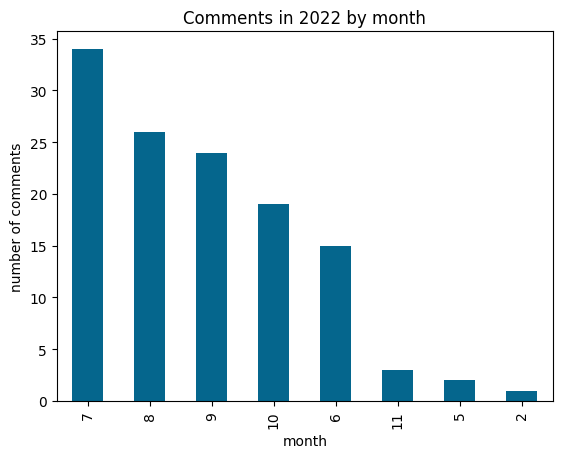

In [104]:
df3 = df2[df2["year"] == 2022]
df4 = df3[df3["comments"] > 0]

df4 = df4.sort_values('month')
df4['month'].value_counts().plot.bar(color='#05668D')
plt.title('Comments in 2022 by month')
plt.xlabel('month')
plt.ylabel('number of comments');

It's not very explicit (and for some reason I just couldn't arrange it by month, sorry about that) but we can see how the number of comments was getting larger with the news for July 2022 being the most popular and than there were less comments again (could be that not to many time passsed yet -- but I doubt it).

Let's take a look at these popular news:

In [105]:
df4[df4["month"] == 7]

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
757,Застройщикам разрешат сносить многоэтажки с не...,Власти официально разрешили застройщикам сноси...,"Кризис, вызванный современными экономическими ...",28,87,9,Экономика,20:00,21,7,2022
761,Ростех переделает часть самолетов в дирижабли,Госкорпорация «Ростех» запланировала на 2022-2...,Предварительной разработкой конструкции дирижа...,24,72,6,"Экономика, Политика",10:00,18,7,2022
35,В России разработают проект перевода английско...,Специалисты Института русского языка Российско...,Главный научный сотрудник ИРЯ РАН Дмитрий Авде...,21,130,27,Наука,16:00,19,7,2022
759,Горьковский автозавод разрабатывает грузовичок...,В Горьком разрабатывают принципиально новый не...,"Новинка имеет рабочее название «Песец», которо...",29,210,15,"Сделано у нас, Экономика",10:00,21,7,2022
758,«Холопам на бирже делать нечего»: в сети опубл...,В начале июля 2022 года на сайт Центрального б...,Экономист Михаил Делягин в своем Telegram-кана...,22,188,8,Экономика,16:33,21,7,2022
33,"В Сколково изобрели нано-монокль, надевающийся...","Резидент Сколково, компания «Поп-Тех» представ...",Толщина монокля составляет всего 100-150 тысяч...,25,150,13,"Наука, Сделано у нас",07:55,21,7,2022
29,Российский сегмент МКС активировал протокол са...,Срочная новость поступила с Международной косм...,В «Роскосмосе» ситуацию комментировать отказал...,32,131,17,"Общество, Наука, Сделано у нас",12:00,31,7,2022
756,В Госдуме рассказали о пользе упаковки для мол...,Депутат от «Единой России» Сергей Меньшаков на...,Вопрос о преимуществах такого вида упаковки ос...,26,75,14,Экономика,14:00,23,7,2022
755,Microsoft добавил возможность выбрать язык Укр...,Корпорация Microsoft выпустила обновление язык...,Как заявил директор Microsoft по разнообразию ...,28,244,17,Экономика,10:10,24,7,2022
753,Российские пенсионеры с 1 августа смогут купит...,Из-за резкого подорожания продуктов питания Ми...,"Купить в магазине, к примеру, половину картофе...",28,364,26,"Общество, Экономика",20:00,24,7,2022


Turns out it was not about number of comments but about number of news piecies in each month.

In [106]:
print('Number of comments in July 2022:', len(df4[df4["month"] == 7]))
print('Number of comments in June 2022:', len(df4[df4["month"] == 6]))
print('Number of comments in August 2022:', len(df4[df4["month"] == 8]))

Number of comments in July 2022: 34
Number of comments in June 2022: 15
Number of comments in August 2022: 26


Maybe it tells us authors have more time in July to "invent" the news (since the news on this webcite are not exactly news)? Or maybe there were some kinds of newsbreaks (I am not sure how to say "инфоповоды" in english) that were referred to on Panorama.

Let's finally look into the key words. First let's try to guess a pattern. Since these news are generally about modern Russia I bet there should be lots of bans!

In [107]:
contain_ban = df2[df2['title'].str.contains('запрет')]
print('There are', len(contain_ban), 'news that tell about some kind of ban which is', round(len(contain_ban)/len(df2['title']), 2), 'of all news.')

There are 36 news that tell about some kind of ban which is 0.03 of all news.


In [108]:
contain_ban

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
763,Ремонт «Северного потока» отложен до сентября ...,Руководство ПАО «Газпром» заявило о невозможно...,В определении Еврокомиссии от 14 марта указано...,26,21,9,Экономика,12:00,17,7,2022
877,"“Здравствуйте, это жёлтый банк”: сотрудникам “...",Сотрудникам банка “Тинькофф” запретили произно...,"Пользователи банка в соцсетях рассказали, что ...",20,599,0,"Экономика, Политика",16:27,24,4,2022
879,“Инопланетяне нас уничтожат и будут правы”: уч...,Комиссия NASA по изучению потенциальных контак...,"Представитель органа Тьерри Рессо, комментируя...",27,270,0,"Общество, Экономика",13:46,22,4,2022
95,Людям с отклонениями по зрению запретят учитьс...,Минздрав и Минобрнауки согласовали список меди...,"Из документа следует, что глубокое изучение то...",23,470,0,"Наука, Общество",16:08,30,1,2022
982,В Белоруссии запретили импорт бананов и киви,МИД Белоруссии объявил о скорейшем введении но...,"Как известно из постановления, эмбарго коснётс...",24,224,0,Экономика,20:38,11,1,2022
1002,Россельхознадзор продлил срок запрета на ввоз ...,Запрет на ввоз в Россию лимонов из Турции прод...,В Россельхознадзоре в ходе исследований собрал...,29,60,0,Экономика,08:45,20,12,2021
1005,Центробанк запретил выдавать кредиты на айфоны,Постановлением Центрального банка России вводя...,Как пояснила председатель Центробанка Эльвира ...,22,413,0,"Общество, Экономика",09:57,13,12,2021
1056,Правительство сняло запрет на вывоз леса в КНДР,Правительство отменило запрет на вывоз необраб...,"«Россия не может оставаться в стороне, когда д...",16,110,0,Экономика,14:31,8,9,2021
1097,Центробанк запретил публиковать курс доллара,Руководство Центробанка сообщило о разработке ...,Запрет затронет все российские интернет-ресурс...,27,155,0,Экономика,17:21,2,7,2021
1105,В России запретят выдавать кредиты меньше милл...,"Комитет Государственной думы по труду, социаль...",«Проблема закредитованности населения сегодня ...,27,130,0,Экономика,10:00,8,6,2021


3%, not bad! How about space and Russia?

In [109]:
contain_space = df2[df2['title'].str.contains('косм')]
print('There are', len(contain_space), 'news that tell about something space related (or rather not since it\'s usually about roskosmos)', round(len(contain_space)/len(df2['title']), 2), 'of all news.')

There are 46 news that tell about something space related (or rather not since it's usually about roskosmos) 0.04 of all news.


In [110]:
contain_space

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
696,СМИ: процедура банкротства «Роскосмоса» заверш...,Процедура банкротства бывшей государственной к...,В настоящий момент компания задолжала государс...,20,87,10,"Общество, Экономика",16:59,16,9,2022
879,“Инопланетяне нас уничтожат и будут правы”: уч...,Комиссия NASA по изучению потенциальных контак...,"Представитель органа Тьерри Рессо, комментируя...",27,270,0,"Общество, Экономика",13:46,22,4,2022
75,"""Роскосмос"" разработал ракетный двигатель, раб...",Режимное КБ №28-4 имени Сергея Королёва разраб...,РД-230К показал отличные экономические качеств...,23,211,0,"Сделано у нас, Наука",21:26,12,4,2022
77,Глава Роскосмоса выступит с просветительской м...,Руководство Роскосмоса получит из федерального...,"«В сегодняшнее тяжелое время нужна, как любят ...",24,181,0,Наука,18:18,12,4,2022
83,Илон Маск рекомендовал NASA покупать космическ...,"Американский предприниматель, основатель Space...",«Рубли можно легко приобрести на Московской ме...,29,129,0,"Наука, Экономика",12:55,3,4,2022
108,У «Роскосмоса» украли c орбиты 4 спутника,«Роскосмос» начал внутреннюю проверку по факту...,«Эти спутники были запущены в середине декабря...,22,233,0,Наука,20:51,14,1,2022
113,Юрий Лоза раскритиковал качество снимков с кос...,Российский музыкант и общественный деятель Юри...,"По словам Лозы, NASA превратилось во всемирное...",22,744,0,"Наука, Общество",20:50,28,12,2021
144,«Роскосмос» построит первый в мире орбитальный...,Госкорпорация «Роскосмос» построит первый в ми...,Для сбора и доставки космического мусора на за...,29,115,0,"Сделано у нас, Наука",14:44,21,10,2021
171,Китайский космический зонд «Тянвэнь-1» сфотогр...,Автоматическая межпланетная станция «Тянвэнь-1...,Название станции «Тянвэнь» переводится как «Во...,19,356,0,Наука,21:59,17,7,2021
181,«Роскосмос» анонсировал перестройку космодрома...,Масштабная реорганизация в несколько раз повыс...,Строительная площадка космодрома сможет удовле...,22,329,0,"Общество, Наука, Сделано у нас",21:46,17,6,2021


In [111]:
contain_russia = df2[df2['title'].str.contains('росс', 'руск')]
print('There are', len(contain_russia), 'news that tell something about Russia', round(len(contain_russia)/len(df2['title']), 2), 'of all news.')

There are 111 news that tell something about Russia 0.09 of all news.


In [112]:
contain_russia

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
1769,Илон Маск пообещал восстановить в Twitter все ...,"Американский предприниматель Илон Маск, ставши...",«Первым я разблокирую моего друга Дональда Тра...,29,78,16,"Общество, Экономика",18:00,28,10,2022
671,ЕС дистанционно выведет из строя камеры видеон...,В рамках подготовки девятого санкционного паке...,Штрафы являются одной из приоритетных статей д...,17,115,20,"Экономика, Политика",20:00,12,10,2022
691,Роскачество: IKEA годами кормила россиян фрика...,Специалисты Роскачества опубликовали результат...,Представитель ведомства подтвердил прессе: это...,20,56,10,"Общество, Экономика",10:00,21,9,2022
701,Крупнейшие японские концерны внедряют российск...,Крупнейшие японские металлургические конгломер...,По словам представителя «Сумимото» Такеши Умба...,28,80,16,Экономика,16:20,14,9,2022
716,IKEA остаётся в России: компанию купил российс...,Бизнесмен Олег Дерипаска стал владельцем контр...,"Дерипска написал в своём Telegram-канале, что ...",19,313,13,Экономика,10:00,3,9,2022
...,...,...,...,...,...,...,...,...,...,...,...
603,На Марсе обнаружена российская военная база,Посадочный модуль автоматической станции Mars ...,"""Нам удалось обнаружить на Марсе казармы, танк...",20,0,0,"Наука, Политика",17:57,29,11,2018
1551,Опрос: большинство россиян считают приватизаци...,"89% россиян считают, что приватизация, проведе...","""Когда наш завод был государственным, я, как и...",19,0,0,"Общество, Экономика",19:18,23,10,2018
1732,"Маттео Сальвини: ""Я слушал российских политико...",В сложной геополитической обстановке сложно на...,- Добрый день! Как вы отважились на это инте...,27,0,0,Статьи,17:00,16,9,2018
1568,Пенсионный фонд объяснил россиянам формулу пен...,В пресс-релизе Пенсионного фонда России появил...,Член коллегии по составлению математической ба...,22,0,0,"Общество, Экономика",11:39,23,8,2018


With "Russia" we guessed nearly 10% of all news -- and that's too much which is exactly why it's a bad key word. It's not accurate enough. So now let's use something more suiting for the task.

In [113]:
from pymystem3 import Mystem

import pymorphy2
from pymorphy2 import MorphAnalyzer

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import collections
from collections import Counter

import string

[nltk_data] Downloading package punkt to /home/anya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Let's figure out the most common __bigrams__ and __trigrams__ in the texts of the news pieces:

In [114]:
m = Mystem()

pattern = r'[0-9«»—]'
nltk.download("stopwords")
sw = nltk.corpus.stopwords.words('russian')

j = 0    
for i in df2['full_text']:
    i1 = i.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(pattern, '', i1)
    lemmas = m.lemmatize(text)
    text = ''.join(lemmas)
    tokens = nltk.word_tokenize(text)
    
    pymorphy_lemmas = [token.replace('ё', 'е') for token in tokens]
    filtered = [w for w in pymorphy_lemmas if w not in sw]

    bigrm = list(nltk.bigrams(filtered))
    frequency = nltk.FreqDist(bigrm)
    for key,value in frequency.items():
        if value >= 5:
            print('Potential key words for\n', df2.iloc[j, 0], '\nare', key, 'with frequency rate', value, '\nVS key words suggested by Panorama:\n', df2.iloc[j, 6], end = '\n\n')
    trigrm = list(nltk.trigrams(filtered))
    frequency = nltk.FreqDist(trigrm)
    for key,value in frequency.items():
        if value >= 2:
            print('Potential key words for\n', df2.iloc[j, 0], '\nare', key, 'with frequency rate', value, '\nVS key words suggested by Panorama:\n', df2.iloc[j, 6], end = '\n\n')
    j += 1

[nltk_data] Downloading package stopwords to /home/anya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Potential key words for
 В связи с санкциями китовое семя в йогуртах Danone заменят пальмовым маслом  
are ('заменитель', 'молочный', 'жир') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potential key words for
 СМИ: процедура банкротства «Роскосмоса» завершится не ранее января  
are ('зарегистрировать', 'товарный', 'знак') with frequency rate 2 
VS key words suggested by Panorama:
 Общество, Экономика

Potential key words for
 Правительство готовится ввести статус квалифицированного собственника  
are ('статус', 'квалифицированный', 'собственник') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика, Общество

Potential key words for
 Страны Таможенного союза введут потолок цен на продукцию компании Apple  
are ('министерство', 'торговля', 'киргизия') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potential key words for
 Советник главы МВФ: «С точки зрения закона после введения санкций все долги России переходят к США 

This way is not perfect at all but if you look through the list of suggestions you can see that some of them make a lot of sence:

Potential key words for
 Американский вуз не смог собрать команду для участия в олимпиаде по физике после отъезда китайских студентов  
are ('массачусетский', 'технологический', 'институт') with frequency rate 2 
VS key words suggested by Panorama:
 Наука, Политика
 
Potential key words for
 Топ-менеджеры АВТОВАЗ выписали себе многомиллионные премии за значительное снижение случаев брака  
are ('отдел', 'контроль', 'качество') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика, Сделано у нас

Potential key words for
 Итоги года. Наука  
are ('итог', 'год') with frequency rate 10 
VS key words suggested by Panorama:
 Наука, Статьи
 
Potential key words for
 Не так страшен ядерный чёрт, как его малюют!  
are ('ядерный', 'война') with frequency rate 6 
VS key words suggested by Panorama:
 Статьи
 
Potential key words for
 Набиуллина: «Мы постоянно читаем мантры о стабильности рубля». Эксклюзивное интервью с главой Центробанка  
are ('российский', 'экономика') with frequency rate 5 
VS key words suggested by Panorama:
 Статьи

__Now let's try another way.__

All the news pieces sure do contain many __named entities__ -- maybe the ones that are mentioned a considorable amount of time can be relevant to the news piece's theme -- and thus be the key words.

In [115]:
#!pip install -U pip setuptools wheel
#!pip install -U spacy

#!python -m spacy download ru_core_news_sm

In [116]:
import spacy.cli
nlp = spacy.cli.download("ru_core_news_sm")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 5.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [117]:
nlp = spacy.load("ru_core_news_sm")

In [118]:
from spacy import displacy
from spacy import tokenizer

I'm going to create a new column in our dataframe where all the named entities for each news piece will be stored (not the named entities themselves but the lemmas).

In [120]:
df2["new tags"] = [[] for _ in range(len(df2))]

In [121]:
for i in range(len(df2)):
    abstr = nlp(df2.iloc[i, 2])
    sentences = list(abstr.sents)
    ents = []
    for e in abstr.ents:
        ents.append(e.lemma_)
    if len(ents) > 0:
        seen_lemmas = {}      
        for ent in ents:
            if ent not in seen_lemmas:
                seen_lemmas[ent] = 1
            else:
                seen_lemmas[ent] += 1
        for k in sorted(seen_lemmas, key=seen_lemmas.get, reverse=True):
            df2.iloc[i, 11].append(k)

df2

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year,new tags
1760,Александр Беглов случайно открыл новую планету...,31 октября Александр Беглов посетил Пулковскую...,"Беглов, который с детства интересуется астроно...",22,385,22,"Общество, Политика, Наука",16:00,2,11,2022,"[беглов, ньютон, флеминга, александр дмитриеви..."
1765,Россия предоставит Турции отсрочку по платежам...,В рамках сделки по созданию в Турции крупного ...,«В случае поражения Эрдогана сделка по создани...,22,80,15,"Экономика, Политика",20:00,2,11,2022,"[эрдоган, александр н., турция, россия]"
1767,Tesla построит электрический танк с автопилотом,Компания Tesla объявила о разработке первого в...,Разработка ведётся под кодовым названием Rhino...,19,158,18,"Политика, Экономика",10:00,1,11,2022,"[пентагон, tesla rhino]"
1763,Жители французских и швейцарских деревень поже...,Жители восьми французских и швейцарских населё...,"Начиная с 1 октября, фермеры и другие труженик...",23,66,8,"Общество, Наука",12:00,29,10,2022,"[бак, зюле, мохаммед аль-тараби, церн]"
1769,Илон Маск пообещал восстановить в Twitter все ...,"Американский предприниматель Илон Маск, ставши...",«Первым я разблокирую моего друга Дональда Тра...,29,78,16,"Общество, Экономика",18:00,28,10,2022,"[дональд трамп, джек дорси, демпартией, госуда..."
...,...,...,...,...,...,...,...,...,...,...,...,...
662,В Дании запретят изучение таблицы Менделеева,Академия наук Дании по рекомендациям националь...,"Согласно постановлению, которое уже поступило ...",24,0,0,"Наука, Общество",13:01,5,1,2018,"[дания, минобразования, министерство иностранн..."
664,В Голливуде построят павильон имитирующий Марс,Один из крупнейших концернов по производству ф...,"""Мы уже имеем опыт сотрудничества с NASA во вр...",21,0,0,Наука,18:25,27,12,2017,"[луна, nasa, марс, калифорния, иа "", совет фед..."
1744,"""Скоро он снова будет со своими мальчиками"". К...",Печальное известие пришло к нам из Рима. В сам...,"Тем не менее, ""радужный кардинал"" (как называл...",22,0,0,Статьи,13:50,21,12,2017,"[лоу, иа ""панорама"", бернард, келли, густаво, ..."
1745,Почему Владимир лучше Парижа,"Это письмо в редакцию ИА ""Панорама"" пришло из ...",Предысторией к письму послужили слова губернат...,23,0,0,"Мнение, Статьи",10:24,21,12,2017,"[париж, владимир, света орлов, лувр, владимирс..."


Let's look at top-25 of these nes tags:

In [122]:
import operator

seen_tags = []
all_tags = {}

for i in range(len(df2)):
    d = df2.iloc[i, 11]
    for j in range(len(d)):
        if d[j] not in seen_tags:
            all_tags[d[j]] = 1
            seen_tags.append(d[j])
        else:
            all_tags[d[j]] += 1

top25_tags = {}            
            
d = Counter(all_tags)
for k, v in d.most_common(25):
    top25_tags[k] = v

print(top25_tags)

{'россия': 469, 'сша': 179, 'москва': 138, 'китай': 86, 'ссср': 74, 'госдума': 69, 'европа': 67, 'белоруссия': 66, 'рф': 64, 'роскосмос': 64, 'центробанк': 63, 'германия': 49, 'сбербанк': 49, 'украина': 42, 'америка': 41, 'ес': 40, 'запад': 40, 'цб': 39, 'рпц': 38, 'сколково': 36, 'ран': 34, 'российский федерация': 34, 'великобритания': 33, 'земля': 33, 'минздрав': 33}


As I successfully guessed before word _Россия_ is extremly popular among the news and for that reason we should exclude it from the plot (so the picture would be more clear). The same applies to _США_.

Now we need some way of comparing new tags to the old ones.

And what are the old tags?

In [123]:
df5 = df2['tag_name'].value_counts()
df5

Экономика                                 421
Наука                                     254
Общество, Экономика                       135
Статьи                                    107
Наука, Общество                            71
Политика, Экономика                        65
Наука, Сделано у нас                       48
Общество, Наука                            27
Экономика, Общество                        18
Экономика, Политика                        17
Книги                                      13
Политика, Статьи                           12
Сделано у нас, Наука                       11
Наука, Статьи                              11
Наука, Политика                            11
Общество, Статьи                            8
Сделано у нас, Экономика                    5
Общество, Политика, Экономика               5
Наука, Экономика                            4
Политика, Наука                             4
Статьи, Политика                            3
Экономика, Сделано у нас          

As we can see there are lots of them. But what if we assume that the first one the most relevant? As we remember each news piece with more than one tag is present in every respective section of Panorama but there has to be some logic -- maybe the first tag corresponds to the primary section?

With this assumption in mind let's build a plot: axis X will represent top-15 new tags, axis Y will represent old tags and the field will show how many articles with each new tag had each old tag (we will exclude new tags _Россия_ and _США_ as they are too frequent and the old tags _Сделано у нас_ (_Made in Russia_), _Мнение_ (_Opinion_) and _Книги_ (_Books_) as they are not frequent enough -- therefore we should get 75 entries):

In [124]:
top_tags = {}

del top25_tags['россия']
del top25_tags['сша']

d = Counter(top25_tags)
for k, v in d.most_common(15):
    top_tags[k] = v

print(top_tags)

{'москва': 138, 'китай': 86, 'ссср': 74, 'госдума': 69, 'европа': 67, 'белоруссия': 66, 'рф': 64, 'роскосмос': 64, 'центробанк': 63, 'германия': 49, 'сбербанк': 49, 'украина': 42, 'америка': 41, 'ес': 40, 'запад': 40}


In [125]:
seen_pairs = []
cross = {}
old_tags = []

for t in top_tags:
    for i in range(len(df2)):
        d = df2.iloc[i, 11]
        if t in d:
            index = re.compile('^([А-Яа-я]+,*?)')
            x = index.findall(df2.iloc[i, 6])
            if x[0] != 'Сделано' and x[0] != 'Мнение' and x[0] != 'Книги':
                if x[0] not in old_tags:
                    old_tags.append(x[0])
                l = ''
                l += t
                l += ','
                l += x[0]
                if l not in seen_pairs:
                    cross[l] = 1
                    seen_pairs.append(l)
                else:
                    cross[l] += 1

for t in top_tags:
    for o in old_tags:
        l = ''
        l += t
        l += ','
        l += o
        if l not in cross:
            cross[l] = 0

print(len(cross))
print(cross)

75
{'москва,Политика': 12, 'москва,Экономика': 43, 'москва,Общество': 15, 'москва,Наука': 16, 'москва,Статьи': 51, 'китай,Политика': 4, 'китай,Общество': 9, 'китай,Наука': 8, 'китай,Экономика': 36, 'китай,Статьи': 28, 'ссср,Общество': 9, 'ссср,Экономика': 24, 'ссср,Политика': 6, 'ссср,Статьи': 22, 'ссср,Наука': 12, 'госдума,Общество': 9, 'госдума,Статьи': 36, 'госдума,Экономика': 13, 'госдума,Политика': 2, 'госдума,Наука': 8, 'европа,Политика': 13, 'европа,Общество': 7, 'европа,Наука': 10, 'европа,Экономика': 17, 'европа,Статьи': 19, 'белоруссия,Экономика': 24, 'белоруссия,Общество': 4, 'белоруссия,Политика': 7, 'белоруссия,Статьи': 23, 'белоруссия,Наука': 8, 'рф,Общество': 10, 'рф,Экономика': 29, 'рф,Наука': 15, 'рф,Политика': 5, 'рф,Статьи': 5, 'роскосмос,Общество': 10, 'роскосмос,Наука': 41, 'роскосмос,Экономика': 1, 'роскосмос,Статьи': 7, 'роскосмос,Политика': 1, 'центробанк,Экономика': 45, 'центробанк,Общество': 8, 'центробанк,Статьи': 9, 'центробанк,Политика': 1, 'германия,Наука'

In [126]:
society = []
economics = []
politics = []
science = []
articles = []

for k in cross.keys():
    index = re.compile('(^[А-Яа-я]+)')
    x = index.findall(k)
    k1 = x[0]
    if old_tags[0] in k:
        for t in top_tags:
            if t in k1:
                politics.append(cross[k])
    if old_tags[1] in k:
        for t in top_tags:
            if t in k1:
                economics.append(cross[k])
    if old_tags[2] in k:
        for t in top_tags:
            if t in k1:
                society.append(cross[k])
    if old_tags[3] in k:
        for t in top_tags:
            if t in k1:
                science.append(cross[k])
    if old_tags[4] in k:
        for t in top_tags:
            if t in k1:
                articles.append(cross[k])

print(politics, len(politics), '\n', economics, len(economics), '\n', society, len(society), '\n', science, len(science), '\n', articles, len(articles))

[12, 4, 6, 2, 13, 7, 5, 1, 1, 6, 4, 5, 5, 5, 2] 15 
 [43, 36, 24, 13, 17, 24, 29, 1, 45, 14, 25, 18, 4, 22, 15] 15 
 [15, 9, 9, 9, 7, 4, 10, 10, 8, 3, 13, 5, 5, 4, 8] 15 
 [16, 8, 12, 8, 10, 8, 15, 41, 3, 1, 5, 10, 4, 5, 0] 15 
 [51, 28, 22, 36, 19, 23, 5, 7, 9, 23, 6, 9, 16, 5, 9] 15


In [127]:
import pygal
from IPython.display import display, HTML

In [128]:
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

In [129]:
#import cairosvg
from pygal.style import Style
custom_style = Style(
  background='transparent',
  plot_background='transparent',
  font_family = 'googlefont:Bad Script',
  colors=('#05668D', '#028090', '#00A896', '#02C39A', '#A9957B'))

#possible colours 1:'#FFCCCC', '#FFAACC', '#CCAAFF', '#CCCCFF', '#CCFFFF'
#possible colours 1:'#05668D', '#028090', '#00A896', '#02C39A', '#A9957B'

dot_chart = pygal.Dot(x_label_rotation=30, style=custom_style)
dot_chart.title = 'Tags crossreference'
dot_chart.x_labels = top_tags
dot_chart.add('Экономика', economics)
dot_chart.add('Статьи', articles)
dot_chart.add('Наука', science)
dot_chart.add('Общество', society)
dot_chart.add('Политика', politics)
#dot_chart.render_to_png('dot.png')

display(HTML(base_html.format(rendered_chart=dot_chart.render(is_unicode=True))))

I think new tags prove to be relevant -- for example, tags _центробанк_, _рф_, _сбербанк_, _запад_ and _ес_ correspond with old tag _Экономика_ (_Economics_) almost exclusivly while new tag _роскосмос_ corresponds with old tag _Наука_. Old tag _Статьи_ (_Articles_) seems to be a bit off but it could be explained if we think about the tag itself -- it doesn't actually refer to the theme of the news piece, it just means it's long enough.

And finally let's take another look at the tags suggested by Panorama and our new tags and see if there is any correlation between their popularity and number of news in the respective section.

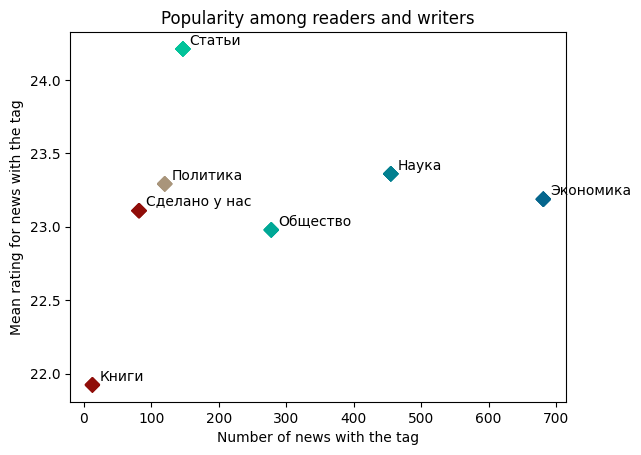

In [130]:
import statistics
dots = ["Наука", "Экономика", "Статьи", "Книги", "Политика", "Общество", "Сделано у нас"]

contain_sc = df2[df2['tag_name'].str.contains(dots[0])]
contain_ec = df2[df2['tag_name'].str.contains(dots[1])]
contain_ar = df2[df2['tag_name'].str.contains(dots[2])]
contain_bo = df2[df2['tag_name'].str.contains(dots[3])]
contain_po = df2[df2['tag_name'].str.contains(dots[4])]
contain_so = df2[df2['tag_name'].str.contains(dots[5])]
contain_ma = df2[df2['tag_name'].str.contains(dots[6])]

sum_sc = []
sum_ec = []
sum_ar = []
sum_bo = []
sum_po = []
sum_so = []
sum_ma = []

j=0
for i in df2['rating']:
    if dots[0] in df2.iloc[j, 6]:
        sum_sc.append(i)
    if dots[1] in df2.iloc[j, 6]:
        sum_ec.append(i)
    if dots[2] in df2.iloc[j, 6]:
        sum_ar.append(i)
    if dots[3] in df2.iloc[j, 6]:
        sum_bo.append(i)
    if dots[4] in df2.iloc[j, 6]:
        sum_po.append(i)
    if dots[5] in df2.iloc[j, 6]:
        sum_so.append(i)
    if dots[6] in df2.iloc[j, 6]:
        sum_ma.append(i)
    j+=1

X = [len(contain_sc), len(contain_ec), len(contain_ar), len(contain_bo), len(contain_po), len(contain_so), len(contain_ma)]
Y = [statistics.mean(sum_sc), statistics.mean(sum_ec), statistics.mean(sum_ar), statistics.mean(sum_bo), statistics.mean(sum_po), statistics.mean(sum_so), statistics.mean(sum_ma)]

for x, y, d in zip(X, Y, dots):
    colors = ['#028090', '#05668D', '#02C39A', '#900D09', '#A9957B', '#00A896', '#900D09']
    plt.scatter(X, Y, s=50, c=colors, marker='D')
    plt.text(x+10, y+0.03, d)
    plt.ylabel('Mean rating for news with the tag')
    plt.xlabel('Number of news with the tag')
    plt.title('Popularity among readers and writers')
plt.show()

In this plot (scarlet dots represent the tags that were not in the previous plot) we see that tags _Books_, _Society_ and _Science_ are as popular among writers as among the readers, while _Economics_ gets a lower rating with more news and the rest tags (_Made in Russia_, _Politics__ and _Articles_) are generally loved by audience -- possibly for humor reasons :)

And now the same for the new tags:

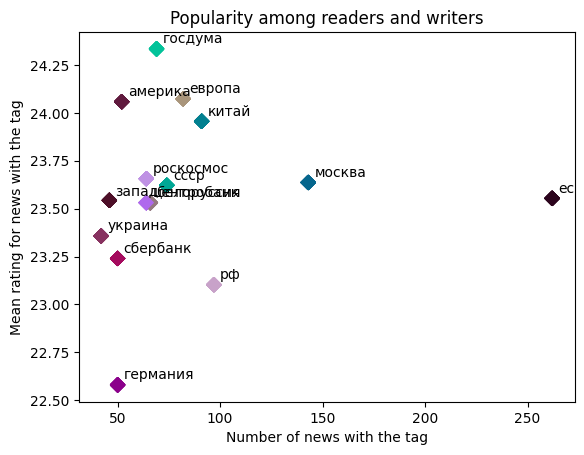

германия, рф, сбербанк, украина, запад, белоруссия, центробанк, ес, роскосмос, ссср, москва, китай, америка, европа, госдума


In [131]:
df2["new tags str"] = ['' for _ in range(len(df2))]
for i in range(len(df2)):
    s = ''
    for j in df2.iloc[i, 11]:
        s += j
        if j != df2.iloc[i, 11][-1]:
            s += ', '
    df2.iloc[i, 12] = s

top_tagsl = []
for k in top_tags.keys():
    top_tagsl.append(k)

dots = top_tagsl

contain_1 = df2[df2['new tags str'].str.contains(top_tagsl[0])]
contain_2 = df2[df2['new tags str'].str.contains(top_tagsl[1])]
contain_3 = df2[df2['new tags str'].str.contains(top_tagsl[2])]
contain_4 = df2[df2['new tags str'].str.contains(top_tagsl[3])]
contain_5 = df2[df2['new tags str'].str.contains(top_tagsl[4])]
contain_6 = df2[df2['new tags str'].str.contains(top_tagsl[5])]
contain_7 = df2[df2['new tags str'].str.contains(top_tagsl[6])]
contain_8 = df2[df2['new tags str'].str.contains(top_tagsl[7])]
contain_9 = df2[df2['new tags str'].str.contains(top_tagsl[8])]
contain_10 = df2[df2['new tags str'].str.contains(top_tagsl[9])]
contain_11 = df2[df2['new tags str'].str.contains(top_tagsl[10])]
contain_12 = df2[df2['new tags str'].str.contains(top_tagsl[11])]
contain_13 = df2[df2['new tags str'].str.contains(top_tagsl[12])]
contain_14 = df2[df2['new tags str'].str.contains(top_tagsl[13])]
contain_15 = df2[df2['new tags str'].str.contains(top_tagsl[14])]

tag_1 = []
tag_2 = []
tag_3 = []
tag_4 = []
tag_5 = []
tag_6 = []
tag_7 = []
tag_8 = []
tag_9 = []
tag_10 = []
tag_11 = []
tag_12 = []
tag_13 = []
tag_14 = []
tag_15 = []

j=0
for i in df2['rating']:
    if top_tagsl[0] in df2.iloc[j, 12]:
        tag_1.append(i)
    if top_tagsl[1] in df2.iloc[j, 12]:
        tag_2.append(i)
    if top_tagsl[2] in df2.iloc[j, 12]:
        tag_3.append(i)
    if top_tagsl[3] in df2.iloc[j, 12]:
        tag_4.append(i)
    if top_tagsl[4] in df2.iloc[j, 12]:
        tag_5.append(i)
    if top_tagsl[5] in df2.iloc[j, 12]:
        tag_6.append(i)
    if top_tagsl[6] in df2.iloc[j, 12]:
        tag_7.append(i)
    if top_tagsl[7] in df2.iloc[j, 12]:
        tag_8.append(i)
    if top_tagsl[8] in df2.iloc[j, 12]:
        tag_9.append(i)
    if top_tagsl[9] in df2.iloc[j, 12]:
        tag_10.append(i)
    if top_tagsl[10] in df2.iloc[j, 12]:
        tag_11.append(i)
    if top_tagsl[11] in df2.iloc[j, 12]:
        tag_12.append(i)
    if top_tagsl[12] in df2.iloc[j, 12]:
        tag_13.append(i)
    if top_tagsl[13] in df2.iloc[j, 12]:
        tag_14.append(i)
    if top_tagsl[14] in df2.iloc[j, 12]:
        tag_15.append(i)
    j+=1

X = [len(contain_1), len(contain_2), len(contain_3), len(contain_4), len(contain_5), len(contain_6), len(contain_7), len(contain_8), len(contain_9), len(contain_10), len(contain_11), len(contain_12), len(contain_13), len(contain_14), len(contain_15)]
Y = [statistics.mean(tag_1), statistics.mean(tag_2), statistics.mean(tag_3), statistics.mean(tag_4), statistics.mean(tag_5), statistics.mean(tag_6), statistics.mean(tag_7), statistics.mean(tag_8), statistics.mean(tag_9), statistics.mean(tag_10), statistics.mean(tag_11), statistics.mean(tag_12), statistics.mean(tag_13), statistics.mean(tag_14), statistics.mean(tag_15)]

for x, y, d in zip(X, Y, dots):
    colors = ['#05668D', '#028090', '#00A896', '#02C39A', '#A9957B', '#957A81', '#C8A2C9', '#BF92E4', '#AF69ED', '#8B008B', '#A50B5E', '#873260', '#601A3E', '#2C041D', '#4D0F28']
    plt.scatter(X, Y, s=50, c=colors, marker='D')
    plt.text(x+3, y+0.03, d)
    plt.ylabel('Mean rating for news with the tag')
    plt.xlabel('Number of news with the tag')
    plt.title('Popularity among readers and writers')
    #plt.legend(loc='best')
plt.show()
print('\033[38;5;55mгермания, \033[38;5;99mрф, \033[38;5;161mсбербанк, \033[38;5;89mукраина, \033[38;5;233mзапад, \033[38;5;134mбелоруссия, \033[38;5;138mцентробанк, \033[38;5;52mес, \033[38;5;132mроскосмос, \033[38;5;37mссср, \033[38;5;24mмосква, \033[38;5;31mкитай, \033[38;5;88mамерика, \033[38;5;94mевропа, \033[38;5;35mгосдума')

Once again we can see that many tags that appear in relatively not as many news pieces are rather popular among readers -- for example, tag _госдума_, _америка_, _европа_ and _китай_ -- probably because corresponding news pieces tend to be funny. And for some reason writer just __love__ writing about _ес_!

In conclusion I want to say that this study most certanly could be continued: other ways of searching for tags and valuing them could be used. Time spent on creating this code was a very well spent time for me: it was quite demanding from time to time but hugely satisfying at the end.

And as for my final project: I intend to do practically the same task only with the base webcite being ruscorpora.ru/
I will be aiming at the contexts in wich verb _броситься_ is used. I will sort them based on the several words following the verb itself (or rather some form of the verb) based on their part of speech and other properties. Since my thesis' topic is "Lexical diachrony in case of verb _броситься_" the code that automatically sorts lots of data is going to be an enormous help.

In [132]:
print("\033[38;5;55mThank You! \u2764\uFE0F")

Thank You! ❤️
